In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from src.models.predictor import TrollPredictor
from umap import UMAP

from src.data_tools.czech_data_tools import load_czech_media_data

In [2]:
# Predictor from Checkpoint
# predictor = TrollPredictor(
#     model_path= "checkpoints/best_model.pt",
#     comments_per_user=10,
#     max_length=64
# )

# Predictor from Hugging Face pretrained model
predictor = TrollPredictor(
    model_name = "ufal/robeczech-base",
    comments_per_user=1,
    max_length=96
)
    

Some weights of RobertaModel were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from pathlib import Path

DATA_DIR = Path('data')
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")


Loading files: 100%|██████████████████████████████████████████████████████████████████| 124/124 [00:11<00:00, 11.05it/s]


Loaded 845764 comments from 66590 unique authors


In [ ]:
# Prepare Single Comment Embeddings
comment_embeddings = []
comment_labels = []
comment_authors = []

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictor.model.to(device)

# Limit the number of comments to 10,000
limited_comments = czech_comments.head(10000)

# Iterate over all comments
for _, row in limited_comments.iterrows():
    comment = row["text"]
    author = row["author"]

    # Tokenize the single comment
    encoded = predictor.tokenizer(
        comment,
        padding=True,
        truncation=True,
        max_length=predictor.max_length,
        return_tensors="pt"
    )

    # Move input tensors to the same device as the model
    encoded = {key: tensor.to(device) for key, tensor in encoded.items()}

    with torch.no_grad():
        # Pass the tokenized input to the TrollDetector model
        outputs = predictor.model(
            input_ids=encoded["input_ids"],
            attention_mask=encoded["attention_mask"],
            tweets_per_account=1  # Single comment
        )
        comment_emb = outputs["account_embedding"].cpu().numpy()

    # Append the embedding and metadata
    comment_embeddings.append(comment_emb)
    comment_authors.append(author)

    # Label if available
    if "troll" in row:
        comment_labels.append(row["troll"])

# Convert to numpy arrays
comment_embeddings = np.vstack(comment_embeddings)
comment_labels = np.array(comment_labels) if comment_labels else None

In [14]:
# Fit Isolation Forest on single comment embeddings
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(comment_embeddings)
scores = -clf.decision_function(comment_embeddings)

# Evaluate if labels are available
if comment_labels is not None:
    print("ROC-AUC:", roc_auc_score(comment_labels, scores))

# Save anomaly scores
results_df = pd.DataFrame({
    "author": comment_authors,
    "comment": limited_comments["text"],
    "anomaly_score": scores
})
results_df.to_csv("single_comment_anomaly_scores.csv", index=False)

In [ ]:
# Plot the distribution of anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(results_df["anomaly_score"], bins=50, color="skyblue", alpha=0.7, edgecolor="black")
plt.title("Distribution of Anomaly Scores (Single Comments)", fontsize=16)
plt.xlabel("Anomaly Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# Sort by anomaly score
results_df = results_df.sort_values("anomaly_score", ascending=False)

# Show top 10 most anomalous comments
print("\nTop 10 most anomalous comments:")
print(results_df.head(10))

# Show top 10 least anomalous comments
print("\nTop 10 least anomalous comments:")
print(results_df.tail(10))
print("Notebook Finished.")

/home/luuka/miniconda/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/luuka/miniconda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


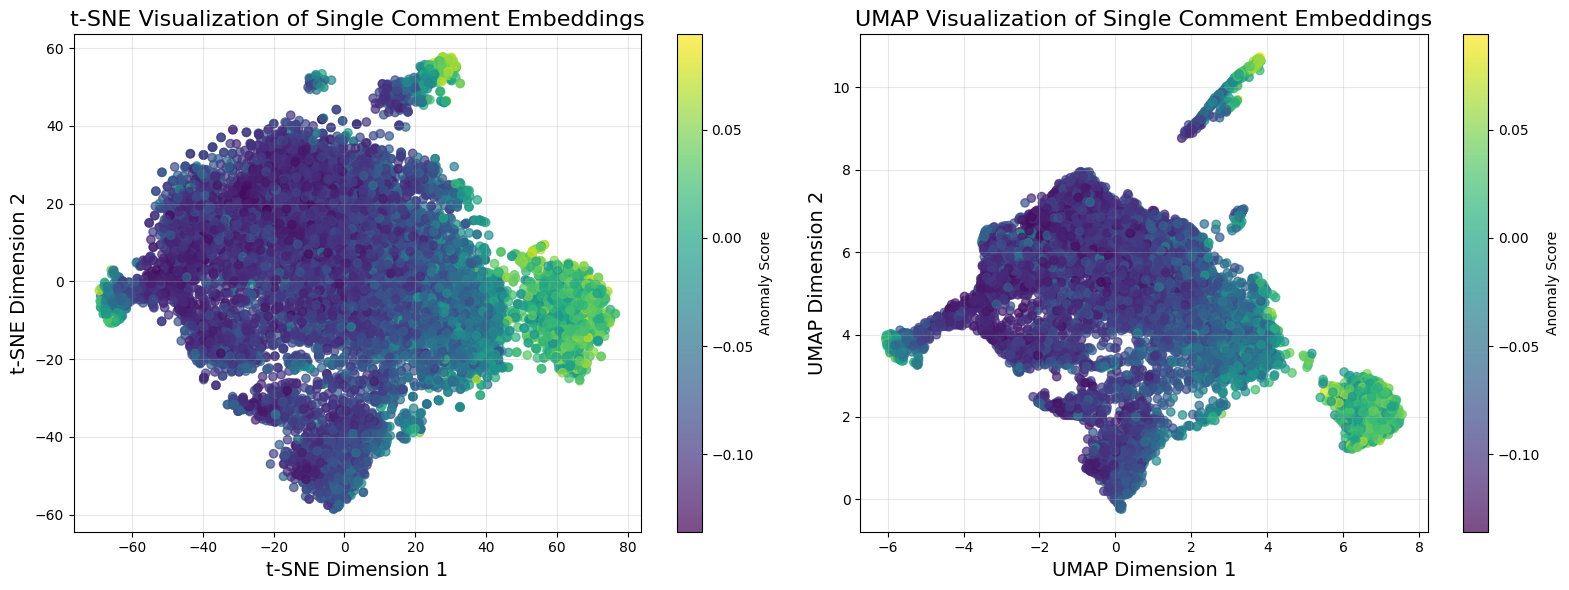

In [42]:
# Perform t-SNE on the single comment embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_embs = tsne.fit_transform(comment_embeddings)

# Perform UMAP on the single comment embeddings
umap = UMAP(n_components=2)
umap_embs = umap.fit_transform(comment_embeddings)

# Create side-by-side plots
plt.figure(figsize=(16, 6))

# t-SNE Plot
plt.subplot(1, 2, 1)
if comment_labels is not None:
    plt.scatter(tsne_embs[:, 0], tsne_embs[:, 1], c=comment_labels, cmap="coolwarm", alpha=0.7)
    plt.colorbar(label="Troll Label")
else:
    plt.scatter(tsne_embs[:, 0], tsne_embs[:, 1], c=scores, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Anomaly Score")
plt.title("t-SNE Visualization of Single Comment Embeddings", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
plt.grid(alpha=0.3)

# UMAP Plot
plt.subplot(1, 2, 2)
if comment_labels is not None:
    plt.scatter(umap_embs[:, 0], umap_embs[:, 1], c=comment_labels, cmap="coolwarm", alpha=0.7)
    plt.colorbar(label="Troll Label")
else:
    plt.scatter(umap_embs[:, 0], umap_embs[:, 1], c=scores, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Anomaly Score")
plt.title("UMAP Visualization of Single Comment Embeddings", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.grid(alpha=0.3)

# Show the plots
plt.tight_layout()
plt.show()

['Uprimne nerozumim tomu, proc povazovali potrat za jedine reseni. V sestem mesici mohli dite normalne porodit, at uz standardne nebo cisarem, a pak udelat maximum, aby prezilo. Predpokladam, ze to by pomohlo i matce, a mohly treba zit obe, aniz by se museli potratem vubec zabyvat. Jinak samozrejme i pokud je potrat jedina cesta, lekar je povinen ji pskytnout. Je to prece volba mezi smrti nenarozeneho ditete, a smrti tehoz ditete i jeho matky. A oni voli smrt obou? Nebo doufali, ze se ta holcina zazracne uzdravi a vsechno bude ruzove? Ceske zdravotnictvi neni dokonale, ale kdyz tohle ctu, jsem zatracene vdecny, ze ho mame.'
 'Jeste, ze nejvetsi starosti rakouskeho prezidenta nebyl bordel v jeho zemi, ale to, aby se premierem nestal lidr viteznych Svobodnych Ono by se to totiz mohlo zacit resit, a to tihle progresivisticti socialisti nechteji dopustit...'
 'Trump 2024 ✌'
 'Jo Ukrajinci jsou nevděční to ví každý o nich je to známo'
 'Iste si Zelenský dokáže nájsť čas aj na prejavy vďaky,

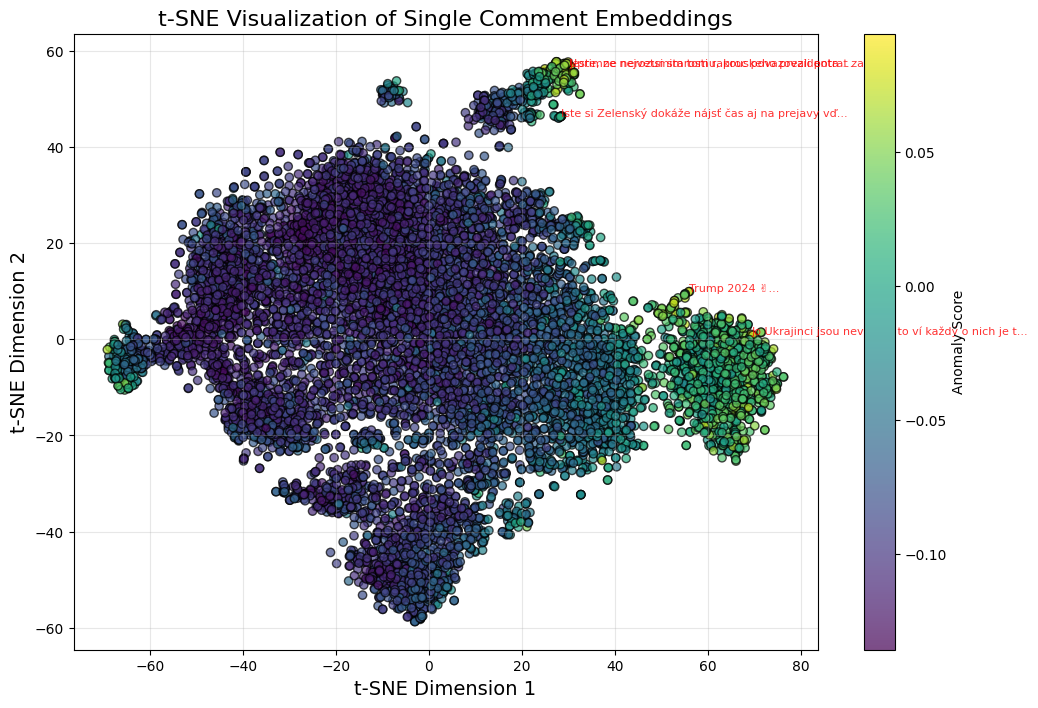

In [41]:
# Select the top 10 most anomalous comments
top_anomalous = results_df.sort_values("anomaly_score", ascending=False).head(5)
print(top_anomalous["comment"].values)

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    tsne_embs[:, 0],
    tsne_embs[:, 1],
    c=scores,
    cmap="viridis",
    alpha=0.7,
    edgecolor="k"
)
plt.colorbar(scatter, label="Anomaly Score")
plt.title("t-SNE Visualization of Single Comment Embeddings", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=14)
plt.ylabel("t-SNE Dimension 2", fontsize=14)
plt.grid(alpha=0.3)

# Annotate the top 10 most anomalous comments
for i, row in top_anomalous.iterrows():
    plt.annotate(
        row["comment"][:50] + "...",  # Truncate long comments
        (tsne_embs[i, 0], tsne_embs[i, 1]),
        fontsize=8,
        color="red",
        alpha=0.8
    )

plt.show()